In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import os
import tensorflow as tf
from IPython import display
from sklearn import metrics
import glob
import sys
from riotwatcher import RiotWatcher
import requests
import json

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

/Users/bailey/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Get all champs in game from static data file (.json)

In [2]:
champfile=os.path.join('lol_data','version6.24.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)

In [3]:
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]

# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline

In [4]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "targets": tf.FixedLenFeature(shape=[1], dtype=tf.int64)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    target = parsed_features['targets']

    return  {'blue_champs':blue_champs, 'red_champs':red_champs}, target

#### Check the parse function worked

In [18]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data','mixed_tier',
                                          'lol_training_data',
                                          'blue_win_lol_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function_win)

ds

<MapDataset shapes: ({blue_champs: (?,), red_champs: (?,)}, (1,)), types: ({blue_champs: tf.int64, red_champs: tf.int64}, tf.int64)>

In [19]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'blue_champs': array([ 67, 120, 122, 555, 131]),
  'red_champs': array([  6,  14,  51,  76, 117])},
 array([1]))

## Model Functions

In [12]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
  
    ds = ds.repeat(num_epochs)
  
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Linear model with vocabulary (all champions)

In [7]:
def construct_hero_categorical_columns(keys,vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])
                                                               

## Define and train the linear model

### Define feature column constructor functions

In [5]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns
        

In [6]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

### Specify path to tfrecord files and construct feature colums

In [9]:
training_file = os.path.join('LOL_data','masters_tier','lol_training_data','lol_training_data.tfrecords')
test_file = os.path.join('LOL_data','masters_tier','lol_test_data', 'lol_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=4)

# Define and train dual head linear (or dnn) model

### Define model function

In [ ]:
# In `model_fn`, specify logits as a dict keyed by head name:
def model_fn(features, labels, mode, params):
    
    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    for units in params['hidden_units_gold']:
        net_gold = tf.layers.dense(net_gold, units=units_gold, activation=tf.nn.relu)
     # Compute logits gold (1 because it is just the predicted diff).
    logits_gold = tf.layers.dense(net_gold, 1, activation=None)
    
    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    for units in params['hidden_units_win']:
        net_win = tf.layers.dense(net_win, units=units_win, activation=tf.nn.relu)
     # Compute logits win (win or lose).
    logits_win = tf.layers.dense(net_win, 2, activation=None)
    
    #collect logits into a single dict
    logits = {'gold_head':logits_gold, 'win_head':logits_win}
    
    # Compute predictions.
    predicted_win = tf.argmax(logits['win_head'], 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_things[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits['win_head']),
            'logits_win': logits['win_head'],
            'gold': logits['gold_head']
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss.
    loss_win = tf.losses.softmax_cross_entropy(labels=labels_win, logits=logits['win_head'])
    loss_gold = tf.losses.huber_loss(labels=labels_win, predictions=logits['win_head'])

In [ ]:
def train_dualhead_linear_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_file,
    test_file):
    """Trains a dual head linear model for a binary classifier and regressor
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        feature_columns: A `set` specifying the input feature columns to use.
        training_examples: A `DataFrame` containing one or more columns from
          `dota2_df` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
          `dota2_df` to use as target for training.
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    win_head = tf.contrib.estimator.binary_classification_head(name=win_head)
    gold_head = tf.contrib.estimator.regressor_head(name=gold_head)
    head = multi_head([win_head,gold_head])
    linear_estimator = tf.estimator.LinearEstimator(
      head=head,
      feature_columns=feature_columns,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
      )
  
    training_input_fn =lambda: _input_fn([training_file])
    test_input_fn =lambda: _input_fn([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        linear_estimator.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(1-evaluation_metrics['accuracy'])
                            
        evaluation_metrics = linear_estimator.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(1-evaluation_metrics['accuracy'])
        
        print('test inaccuracy', 1-evaluation_metrics['accuracy'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training inaccuracy')
    plt.plot(test_acc,label='Test inaccuracy')
    plt.plot(evaluation_metrics['accuracy_baseline']*np.ones(periods),label='Baseline Inaccuracy')
    plt.legend()
    plt.show()
    
    return linear_estimator


### Train a dual head linear classifier and regressor

In [ ]:
training_file = os.path.join('lol_data','masters_tier','lol_training_data','lol_training_data.tfrecords')
test_file = os.path.join('lol_data','masters_tier','lol_test_data','lol_test_data.tfrecords')

trained_dualhead_linear_model = train_dualhead_linear_model(
    learning_rate=0.003,
    steps=5e5,
    batch_size=2000,
    feature_columns=construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab),
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [24]:
validation_file = os.path.join('LOL_data','masters_tier','lol_validation_data', 'lol_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dualhead_linear_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e3)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

accuracy 0.5495492
accuracy_baseline 0.50042677
auc 0.5685406
auc_precision_recall 0.5591297
average_loss 0.6860394
label/mean 0.50042677
loss 34.295567
precision 0.5458012
prediction/mean 0.507441
recall 0.5950433
global_step 3000


### Investigate embeding layer

In [79]:
champ_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

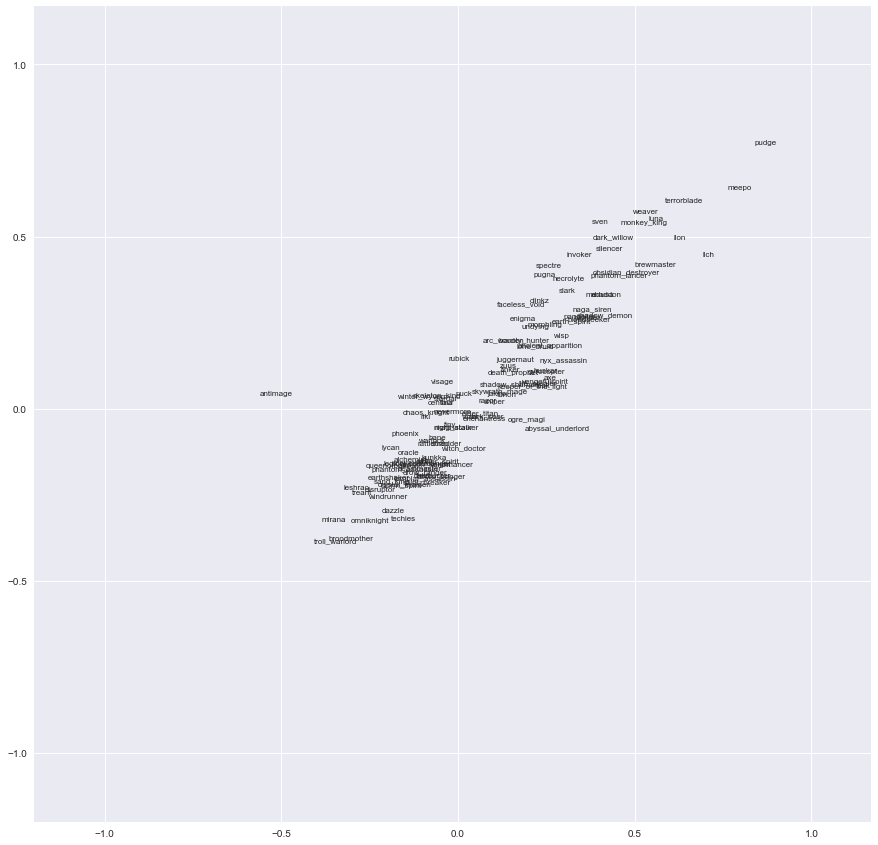

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
red_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/red_champs_embedding/embedding_weights')

blue_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/blue_heroes_embedding/embedding_weights')

for champ_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    red_vector = np.zeros(len(vocab))
    red_vector[champ_index] = 1
    blue_vector = np.zeros(len(vocab))
    blue_vector[champ_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    red_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    blue_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(blue_embedding_xy[0],
           blue_embedding_xy[3],
           champ_list[champ_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.ylim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.show() 

### Save a trained model later exploration, or for on-demand prediction of test cases

In [20]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    
    features = {'blue_champs':radiant_heroes, 'red_champs': dire_heroes}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [21]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1554789124'